_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens, Dr. Alexander Ecker

Tutors: Sarah Strauss, Santiago Cadena

Summer term 2019

Due date: 2019-06-04, 9am

Name: Guillem Boada-Gardenyes, Peter El-Jiz, Ulzii-Utas Narantsatsralt

# Exercise sheet 6



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from numba import jit, cuda, vectorize
from scipy import special

mpl.rc("savefig", dpi=72)

import itertools

sns.set_style('whitegrid')
%matplotlib inline

## Task: Implement entropy estimators




### General framework

Entropy is defined as 

$$
H[p] = -\sum_x p_x \log p_x
$$

where $p_x = p(x=X)$. Here we assume that $X$ is a discrete random variable and that there are finitely many states $K$ that $X$ can take.

We are interested in the entropy of discrete random variables, because of its relationship with mutual information:

$$
I[X|Y] = H[X] - H[X|Y]
$$

If we can estimate the entropy well, we can estimate the mutual information well. An application in neuroscience would be estimating the mutual information between a spike train modeled as a sequence of $1$s and $0$s (e.g. $(0,1,0,1,1)$) and a discrete set of stimuli.

Note that a multivariate binary distribution modeling a spike train can always be mapped to a discrete univariate distribution, $\mathbb{Z}_2 \longrightarrow \mathbb{Z_+}$, by interpreting each binary state $z \in \mathbb{Z}_2$ as its corresponding binary number and computing $f(z) = \sum_i 2^{i} z_i$.

As discussed in the lecture, the problem is that one always underestimates the true entropy of a distribution from samples. In this exercise you are meant to implement different estimators for discrete entropy and evaluate them on different discrete distributions:

* Uniform distribution: $p(x=X) = \frac{1}{K}$

* "Zipf's law"- distribution: $p(x=X) = \frac{1}{Z x} $, where $Z = \sum_k 1/k$

There is a really good series of blog posts about discrete entropy estimation to be found [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-1.html), [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-2.html) and [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-3.html). 

Make sure you use binary logarithms throughout.


### Implementation of the estimators

Implement the

* maximum likelihood estimator (1 pt)
* miller-maddow corrected estimator (1 pt)
* jack-knife corrected estimator (2 pt)
* coverage adjusted estimator (1 pt).

When implementing the jack-knife estimator, you may want to restrict the amount of resampling for performance reasons e.g. to 1000, even if more samples are available. By definition, $0\log0=0$. Adapt the interfaces as needed for your implementation.

In addition, implement or use one of the following more advanced estimators (1+3 pts, extra points if you use your own implementation):

* [JVHW estimator](https://arxiv.org/abs/1406.6956) with code on [github](https://github.com/EEthinker/JVHW_Entropy_Estimators/tree/master/Python)
* [Unseen estimator](http://papers.nips.cc/paper/5170-estimating-the-unseen-improved-estimators-for-entropy-and-other-properties) (includes Matlab code in Supplementary)
* [Best Upper Bounds estimator](http://www.mitpressjournals.org/doi/abs/10.1162/089976603321780272) (Matlab code available on Ilias)

For this part, you are allowed to use an existing implementation as well.


In [2]:
@jit
def entropy_mle(phat):
    '''
    Maximum likelihood or plug-in estimator of discrete entropy
    
    phat:    estimate of the distribution / histogram
    H:       entropy estimate
    '''
    
    phat = phat[phat != 0];
    H = -np.sum(phat*np.log2(phat));
    
    
    return H

In [3]:
@jit
def entropy_mm(phat, n):
    '''
    Miller-Maddow corrected estimator of discrete entropy
    
    phat:    estimate of the distribution / histogram
    n:       sample size
    H:       entropy estimate
    '''
    
    dhat = np.count_nonzero(phat > 0);
    
    phat = phat[phat != 0];
    H = -np.sum(phat*np.log2(phat));
    
    H = H + (dhat - 1)/(2*n);
    
    return H

In [4]:
@jit
def entropy_jk(x, edges):
    '''
    Jack-knife corrected estimator of discrete entropy   
    
    '''

    n = len(x);
    H_dot = 0;
    
    for i in range(n):
        boolean_index = np.ones(n, dtype=bool);
        boolean_index[i] = False;
        
        phat = np.histogram(x[boolean_index],edges)[0]
        phat = phat / (n-1);
                
        phat_tmp = phat[phat != 0];
        H_tmp = -np.sum(phat_tmp*np.log2(phat_tmp));

        H_dot += H_tmp;
        
    H_dot = H_dot/n;
    
    phat = np.histogram(x,edges)[0]
    phat = phat / n;
    
    phat = phat[phat != 0];
    H = -np.sum(phat*np.log2(phat));
    
    H = n * H - (n-1)*H_dot;
    
    return H

In [5]:
@jit
def entropy_cae(phat, n):
    '''
    coverage-adjusted estimator of discrete entropy
    
    phat:    estimate of the distribution / histogram
    n:       sample size
    H:       entropy estimate
    '''
    
    C = 1 - np.count_nonzero(phat == 1)/n;
    pc_hat = phat * C;
        
    pc_hat = pc_hat[pc_hat != 0];    
    H = -np.sum((pc_hat * np.log2(pc_hat))/(1 - (1 - pc_hat)**n));
    
    return H

In [6]:
from est_entro import est_entro_JVHW

def entropy_jvwh(x):
    '''
    JVHW estimator of discrete entropy
    

    '''
    
    H  = est_entro_JVHW(x);    
    
    return H

### Uniform distribution

In [54]:
D = 10
N = 2**D

p = 1/N * np.ones(N)   # true distribution

H = - np.sum(p * np.log2(p))  # true entropy

Sample from the uniform distribution using sample sizes of 100 and 10000. Plot the true distribution and the sampled distributions. What do you notice? (1 pt)

In [13]:
a = 0;
b = 1;
uni_100 = np.random.uniform(a,b,100);
uni_10000 = np.random.uniform(a,b,10000);

uni_true = 1/(b - a);

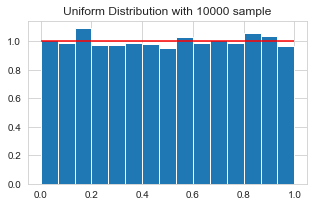

In [14]:
plt.figure(figsize=(5,3));
plt.hist(uni_10000, 15, density=True);
plt.hlines(uni_true,a,b, color = 'r');
plt.title('Uniform Distribution with 10000 sample');

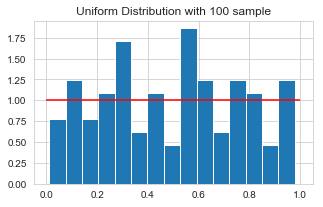

In [63]:
plt.figure(figsize=(5,3));
plt.hist(uni_100, 15, density=True);
plt.hlines(uni_true,a,b, color = 'r'); 
plt.title('Uniform Distribution with 100 sample');

We can see that as the sample size grows, the distribution gets closer to the true distribution.

Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [158]:
sampleSz = np.round(np.logspace(1,5,num=10))
nRuns = 30

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sampleSz),nRuns))
h_mm = np.zeros((len(sampleSz),nRuns))
h_jk = np.zeros((len(sampleSz),nRuns))
h_cae = np.zeros((len(sampleSz),nRuns))
h_jvhw = np.zeros((len(sampleSz),nRuns))

for i, S in enumerate(sampleSz):
    for j in np.arange(nRuns):
        
        # add sampling here...        
        x = np.random.randint(N, size = int(S));

        phat = np.histogram(x,edges)[0]
        phat = phat / S

        h_mle[i,j] = entropy_mle(phat);
        h_mm[i,j] = entropy_mm(phat, S);
        h_cae[i,j] = entropy_cae(phat, S);
        h_jk[i,j] = entropy_jk(x, edges);
        h_jvhw[i,j] = entropy_jvwh(x)
        


Plot the resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

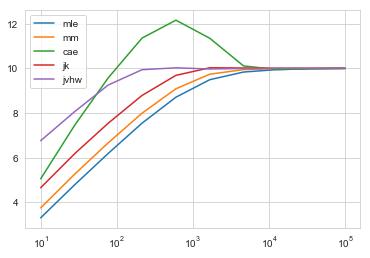

In [159]:
plt.semilogx(sampleSz,np.mean(h_mle, axis=1));
plt.semilogx(sampleSz,np.mean(h_mm, axis=1));
plt.semilogx(sampleSz, np.mean(h_cae, axis=1));
plt.semilogx(sampleSz,np.mean(h_jk, axis=1));
plt.semilogx(sampleSz,np.mean(h_jvhw, axis=1))


plt.legend(['mle', 'mm',  'cae', 'jk', 'jvhw'])


The JVHW is the fastest one that converse. Around 10^2 we can see already very good approximation.

### Zipf distribution

[Zipf's law ](https://en.wikipedia.org/wiki/Zipf%27s_law) refers to a family of power law like distributions for which $p_k \sim 1/k^d$. We will simply use $d=1$ here.   

Adapt the framework above to sample from a Zipf distribution and evaluate the estimators for this case. Are there differences to the uniform case? (3 pts)

In [7]:
D = 10
N = 2**D

p = 1/(np.arange(0,N)+1)    # true distribution
p = p/np.sum(p)

H = - np.sum(p * np.log2(p))  # true entropy

print(H)

7.510649703297878


Sample from the Zipf distribution using sample sizes of 100 and 10000. In this case, the function `random.choice` is very helpful for sampling. Plot the true distribution and the sampled distributions. What do you notice? (1 pt)

In [8]:
zipf_100 = np.random.choice(np.arange(0,N), size = 100, p = p);
zipf_10000 = np.random.choice(np.arange(0,N), size = 10000, p = p);

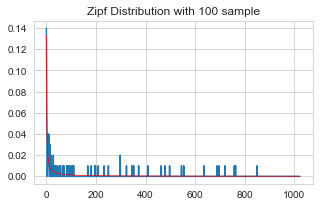

In [9]:
phat = np.histogram(zipf_100,np.arange(-0.5, N, 1))[0];
phat = phat / 100;
plt.figure(figsize=(5,3));
plt.plot(phat);
plt.plot(p, linewidth = 0.7, color = 'r');
plt.title('Zipf Distribution with 100 sample');

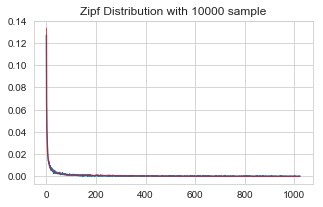

In [10]:
phat = np.histogram(zipf_10000,np.arange(-0.5, N, 1))[0];
phat = phat / 10000;
plt.figure(figsize=(5,3));
plt.plot(phat);
plt.plot(p, linewidth = 0.7, color = 'r');
plt.title('Zipf Distribution with 10000 sample');

Same as uniform distribution, large sample size causes the distribution to be same as the true distributino.

Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [11]:
sampleSz = np.round(np.logspace(1,5,num=10))
nRuns = 30
edges = np.arange(-0.5, N, 1)
x_arr = np.arange(0,N);

h_mle = np.zeros((len(sampleSz),nRuns))
h_mm = np.zeros((len(sampleSz),nRuns))
h_jk = np.zeros((len(sampleSz),nRuns))
h_cae = np.zeros((len(sampleSz),nRuns))
h_jvhw = np.zeros((len(sampleSz),nRuns))

for i, S in enumerate(sampleSz):
    for j in np.arange(nRuns):
        
        # add sampling here
        x = np.random.choice(x_arr, size = int(S), p = p);
        
        phat = np.histogram(x,edges)[0]
        phat = phat / S
        
        h_mle[i,j] = entropy_mle(phat)
        h_mm[i,j] = entropy_mm(phat, S)
        h_cae[i,j] = entropy_cae(phat, S)
        h_jk[i,j] = entropy_jk(x, edges)
        
        h_jvhw[i,j] = entropy_jvwh(x)
        


Plot resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

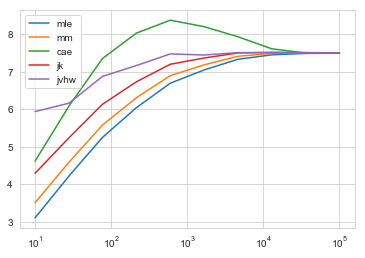

In [12]:
plt.semilogx(sampleSz,np.mean(h_mle, axis=1))

plt.semilogx(sampleSz,np.mean(h_mm, axis=1))
plt.semilogx(sampleSz, np.mean(h_cae, axis=1))
plt.semilogx(sampleSz,np.mean(h_jk, axis=1))
plt.semilogx(sampleSz,np.mean(h_jvhw, axis=1))


plt.legend(['mle', 'mm',  'cae', 'jk', 'jvhw'])


The JVHW is the fastest one that converse. less than 10^3 we can see already very good approximation.